In [59]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

## Read data

In [64]:
import xarray as xr

filename = "OBS6_ERA5_reanaly_1_day_pr_2000-2018_newbasin.nc"  # Update the path to the correct location of the file
# Read the NetCDF file
ds = xr.open_dataset(filename)
# Convert to a pandas DataFrame
df = ds.to_dataframe()
# Reset the index if needed
df.reset_index(inplace=True)
df = df[df['bnds'] == 0]
df.index = pd.to_datetime(df['time'])
df.index = df.index.normalize()
df.drop(columns=['time', 'bnds'], inplace=True)
prec  = df['pr']  # Precipitation data
prec  = prec*86400  # Convert from m/s to mm/day)
prec[prec < 0] = 0  # Set negative values to zero


filename = "Derived_Makkink_evspsblpot_newbasin.nc"  # Update the path to the correct location of the file
# Read the NetCDF file
dsEP = xr.open_dataset(filename)
# Convert to a pandas DataFrame
dfEP = dsEP.to_dataframe()
# Reset the index if needed
dfEP.reset_index(inplace=True)
EP = dfEP['evspsblpot']  # Evapotranspiration data
EP.index = pd.to_datetime(dfEP['time'])
EP.index = EP.index.normalize()
EP = EP*86400  # Convert from mm/s to mm/day)
EP[EP < 0] = 0  # Set negative values to zero


filename = "Upstream_Q.txt"
A = 17002.553 *10**6 #m^2
dfQ = pd.read_csv(filename, delim_whitespace=True, skiprows=1, header=None, encoding='latin1')  # Specify encoding
dfQ = dfQ[[0, 3]]  # Select only the first and third columns
dfQ.columns = ['Date', 'Q']  # Rename columns for clarity
dfQ['Date'] = pd.to_datetime(dfQ['Date'], format='%Y-%m-%d')  # Convert 'Date' column to datetime
dfQ.set_index('Date', inplace=True)  # Set 'Date' as the index
dfQ['Q'] = (dfQ['Q']/A)*(10**3) #mm/day


C:\Users\margh\AppData\Local\Temp\ipykernel_23144\2286975615.py:35: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dfQ = pd.read_csv(filename, delim_whitespace=True, skiprows=1, header=None, encoding='latin1')  # Specify encoding


## Water Balance canopy interception

With this exercise we used the water balance to calculate the storage in the canopy interception and the throughfall with the data of precipitation and potential evaporation from 2000 to 2019. A few hypothesis were made:  
1.	The water available in the storage evaporates at a rate equal to the potential evaporation. 
2.	The maximum value of water interception in the canopy was assumed equal to 2.5 mm (find possible real value).
3.	The interception storage is assumed to be empty before the first day given in the data.


In [70]:
n = len(prec)
t = np.arange(n)
Si1 = np.zeros(n)
Si2 = np.zeros(n)
Si_max = 2.5 #?????????????????????????????????????????????????????????????????''
Pe_1 = np.zeros(n)
Pe_2 = np.zeros(n)

for t in np.arange(1,n,1):

    Si1[t] = Si1[t-1] + prec.iloc[t]  # Use .iloc to get the scalar value
    if Si1[t] > Si_max:
        Pe_1[t] = Si1[t] - Si_max
    else:
        Pe_1[t] = 0
    Si1[t] = Si1[t] - Pe_1[t]
    deltS = Si1[t] - EP.iloc[t]  # Use .iloc to get the scalar value
    Si1[t] = np.maximum(0, deltS)

Pe_1_mean = Pe_1.mean()


print(Pe_1_mean/prec.mean())


0.589065817103928


In [71]:
print(len(prec.index))
print(len(EP.index))
print(len(dfQ.index))
print(len(Si1))
print(len(Pe_1))


6940
6940
6940
6940
6940


In [76]:
data = pd.DataFrame({'P': prec, 'EP': EP, 'Q': dfQ['Q'].values, 'S': Si1, 'Pe': Pe_1}, index=prec.index)
data.head(15)

,P,EP,Q,S,Pe
time,,,,,
2000-01-01,0.004437,1.156963,0.000000,0.000000,0.000000
2000-01-02,0.000000,1.175265,0.082691,0.000000,0.000000
2000-01-03,0.020500,1.067080,0.079740,0.000000,0.000000
2000-01-04,0.000000,1.165309,0.077725,0.000000,0.000000
2000-01-05,0.000000,1.169341,0.073602,0.000000,0.000000
2000-01-06,0.000818,1.187644,0.070334,0.000000,0.000000
2000-01-07,0.000000,1.214381,0.062506,0.000000,0.000000
2000-01-08,0.000000,0.946409,0.067407,0.000000,0.000000
2000-01-09,1.873820,1.022426,0.064993,0.851395,0.000000


<Axes: xlabel='time'>

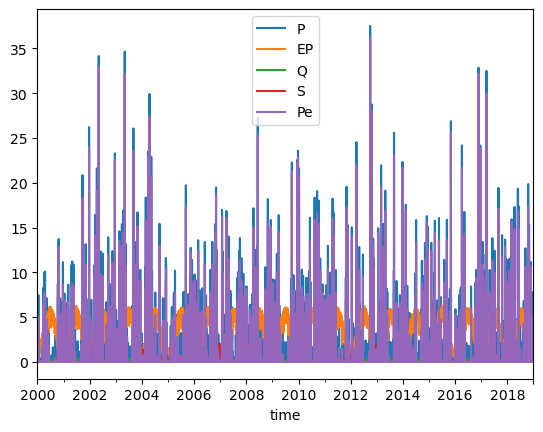

In [77]:
data.plot()

**Ratio of long—term mean throughfall Pe over long-term mean precipitation**

In [73]:
P = data['P'].mean()
Pe = data['Pe'].mean()

print(Pe/prec.mean())

0.589065817103928


Meaning that circa 60% of the rain reaches the soil.

## Rootzone Capacity

The Rootzone Storage Capacity (water volume SR that does not drain away and that is accessible to plants in the unsaturated zone) was also estimated in this exercise using the water balance. As there is evidence that vegetation designs its root system in a way that it has sufficient access to water to bridge dry periods with return periods of 10-20 years, to calculate SR we found the maximum storage deficit in our data (19 years).

In [80]:
P_mean = data['P'].mean()
EP_mean = data['EP'].mean()
Q_mean = data['Q'].mean()

ET_mean = P_mean - Q_mean #transpiration

#print (P_mean, EP_mean, Q_mean, ET_mean)

data.loc[:,'ET'] = (data['EP']/EP_mean)*ET_mean

data.loc[:,'P-ET'] = data['P'] - data['ET']


for i in range(1, len(data)):
    if data['P-ET'].iloc[:i].cumsum().iloc[-1] > 0:
        data.loc[data.index[i], 'SD'] = 0
    else:
        data.loc[data.index[i], 'SD'] = data['P-ET'].iloc[:i].cumsum().iloc[-1]


SR = data['SD'].min()
        
print(f'Rootzone storage:{-SR} mm')

Rootzone storage:222.73762464012785 mm
